In [1]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

from src.settings import get_settings
from src.utils.logger import create_logger

settings = get_settings()
logger = create_logger(path=settings.paths.logs_dir)
logger.debug(f"settings loaded as \n{settings.model_dump_json(indent=2)}")

09:06 PM | __main__ | DEBUG     | settings loaded as 
{
  "models": {
    "hf": {
      "chat": "meta-llama/Llama-3.1-8B-Instruct",
      "embedding_snowflake": "Snowflake/snowflake-arctic-embed-l-v2.0",
      "embedding_specter": "allenai/specter2_base",
      "encoder": "m3rg-iitd/matscibert",
      "reranker": "Qwen/Qwen3-Reranker-0.6B"
    },
    "nebius": {
      "reasoning": "zai-org/GLM-4.5-Air",
      "tool_user": "Qwen/Qwen3-30B-A3B-Instruct-2507",
      "chat": "meta-llama/Meta-Llama-3.1-8B-Instruct-fast",
      "embedding_baai_bge": "BAAI/bge-multilingual-gemma2"
    }
  },
  "paths": {
    "base_dir": "/home/rudy/code/lattice",
    "data_dir": "/home/rudy/code/lattice/data",
    "logs_dir": "/home/rudy/code/lattice/logs",
    "agents_dir": "/home/rudy/code/lattice/agents",
    "skills_dir": "/home/rudy/code/lattice/skills",
    "tools_dir": "/home/rudy/code/lattice/tools"
  }
}


# 1. hello world graph

In [7]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [8]:
class AgentState(TypedDict):
    message: str


def greeting_node(state: AgentState) -> AgentState:
    """Simple node that adds a greeting message

    Args:
        state (AgentState): Agent State

    Returns:
        AgentState: Updated state
    """
    state["message"] = f"hello world with {state['message']}"
    return state

In [9]:
graph = StateGraph(AgentState)
graph.add_node("greeter", action=greeting_node)
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

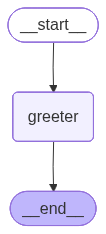

In [12]:
app

In [13]:
result = app.invoke({"message": "republic day"})

In [14]:
result

{'message': 'hello world with republic day'}

# 2. multiple inputs graph

In [22]:
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph

In [23]:
class AgentState(TypedDict):
    values: List[int]
    name: str
    result: Optional[str]

In [31]:
def process_values(state: AgentState) -> AgentState:
    """process values

    Args:
        state (AgentState): input state

    Returns:
        AgentState: output state
    """
    print(state)
    state["result"] = f"Hi there {state['name']}. The value is {sum(state['values'])}."
    print(state)
    return state

In [32]:
graph = StateGraph(AgentState)
graph.add_node("processor", action=process_values)
graph.set_finish_point("processor")
graph.set_entry_point("processor")
app = graph.compile()

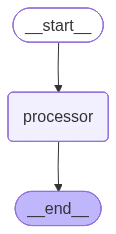

In [33]:
app

In [ ]:
result = app.invoke({"name": "Bob", "values": [1, 2, 3, 4]})  # type: ignore

{'values': [1, 2, 3, 4], 'name': 'Bob'}
{'values': [1, 2, 3, 4], 'name': 'Bob', 'result': 'Hi there Bob. The value is 10.'}


In [30]:
result

{'values': [1, 2, 3, 4],
 'name': 'Bob',
 'result': 'Hi there Bob. The value is 10.'}

# 3. Build agents

In [2]:
from typing import List, TypedDict, Union

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

In [3]:
model = ChatOpenAI(
    model=settings.models.hf.chat,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,  # type: ignore
    temperature=0.01,
)

In [4]:
response = model.invoke([HumanMessage(content="Hello")])

In [8]:
logger.info(response.to_json())

09:15 PM | __main__ | INFO      | {'lc': 1, 'type': 'constructor', 'id': ['langchain', 'schema', 'messages', 'AIMessage'], 'kwargs': {'content': "It's nice to meet you. Is there something I can help you with or would you like to chat?", 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'meta-llama/llama-3.1-8b-instruct', 'system_fingerprint': '', 'id': '39a9e8a54f804b53b440b24102187d8e', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'id': 'lc_run--019bfafa-1eaa-7f41-9c7f-5b0f30238466-0', 'usage_metadata': {'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59, 'input_token_details': {}, 'output_token_details': {}}, 'tool_calls': [], 'invalid_tool_calls': []}}


In [21]:
class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]


def process(state: AgentState) -> AgentState:
    print(f"\nHuman: {state['messages'][-1].content}")
    response = model.invoke(state["messages"])
    print(f"\nAI: {response.content}")
    state["messages"].append(response)
    return state

In [22]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

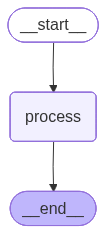

In [23]:
agent

In [27]:
user_input = input("Enter: ")
response = agent.invoke({"messages": [HumanMessage(content=user_input)]})


Human: my name is bob

AI: Nice to meet you, Bob. Is there something I can help you with or would you like to chat?


In [30]:
response["messages"].append(HumanMessage(content="What is my name?"))
response = agent.invoke(response)
response


Human: What is my name?

AI: Your name is Bob.


{'messages': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob. Is there something I can help you with or would you like to chat?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 39, 'total_tokens': 62, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'meta-llama/llama-3.1-8b-instruct', 'system_fingerprint': '', 'id': '3cebc6d5d8bc4e3484a8dbca22d43d97', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bfa9a-8cfa-7c00-a8a0-13d3dd35e175-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 39, 'output_tokens': 23, 'total_tokens': 62, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Your name is Bob.', additional_kwargs={'refusal': None}, resp